In [144]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt

# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Robin

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Robin

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

For next time: see if we have a monopol of honey in some countries

In [203]:
def plot_time_serie(df, ylabel="", xlabel="", title=""):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(df, linestyle='-')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    fig.show()

In [206]:
def plot_time_series(df, names, ylabel="", xlabel="", title=""):
    fig, ax = plt.subplots(figsize=(15,6))
    dfs =[df[name] for name in names]
    for df, name in zip(dfs, names):
        ax.plot(df, linestyle='-', label=name)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    

In [214]:
honey_production_raw = pd.read_csv("data/FAOSTAT_Livestock_Primary.csv", encoding="latin_1")

honey_production = honey_production_raw[(honey_production_raw["Item"] == "Honey, natural") & (honey_production_raw["Unit"] == "tonnes")]
honey_production = honey_production[["Area", "Year", "Value"]]
honey_production = honey_production.rename(columns={"Area": "Country", "Value": "Production Value"})

In [150]:
honey_year_production = honey_production.groupby("Year")["Production Value"].sum()

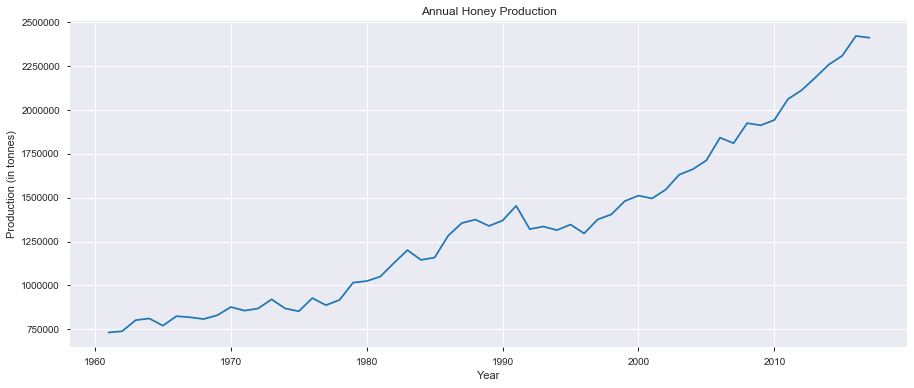

In [200]:
plot_time_serie(honey_year_production, 'Production (in tonnes)', 'Year', 'Annual Honey Production')

In [118]:
trade_matrix = pd.read_csv("data/FAOSTAT_Trade_Matrix.csv", encoding="latin_1")
honey = trade_matrix[(trade_matrix["Item"] == "Honey, natural")]
honey_imports = honey[(trade_matrix["Element"] == "Import Quantity")]
honey_imports = honey_imports[["Reporter Countries", "Year", "Value"]]
honey_imports = honey_imports.rename(columns={"Reporter Countries": "Country", "Value": "Import Value"})
honey_exports = honey[(trade_matrix["Element"] == "Export Quantity")]
honey_exports = honey_exports[["Reporter Countries", "Year", "Value"]]
honey_exports = honey_exports.rename(columns={"Reporter Countries": "Country", "Value": "Export Value"})

In [120]:
exports_country = honey_exports.groupby(["Year", "Country"]).agg('sum')
imports_country = honey_imports.groupby(["Year", "Country"]).agg('sum')

In [168]:
new_df = pd.merge(honey_production, exports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
new_df = pd.merge(new_df, imports_country,  how='inner', left_on=['Year','Country'], right_on = ['Year','Country'])
new_df["Honey Consumption"] = new_df["Production Value"] - new_df["Export Value"] + new_df["Import Value"]
new_df["Balance"] = new_df["Export Value"] - new_df["Import Value"]
new_df = new_df.set_index('Year')

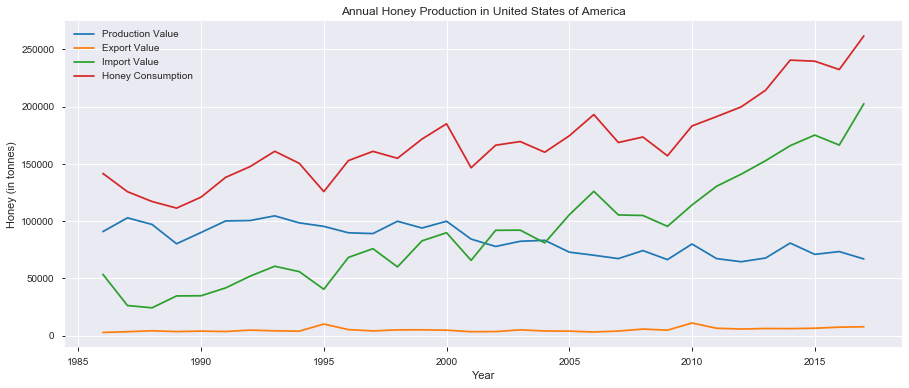

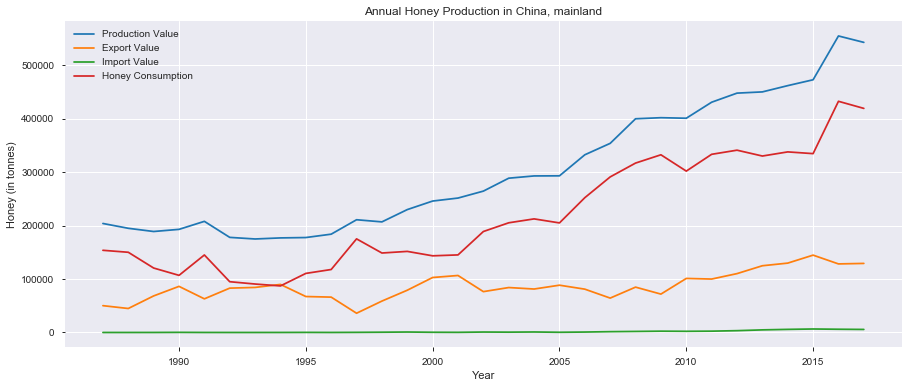

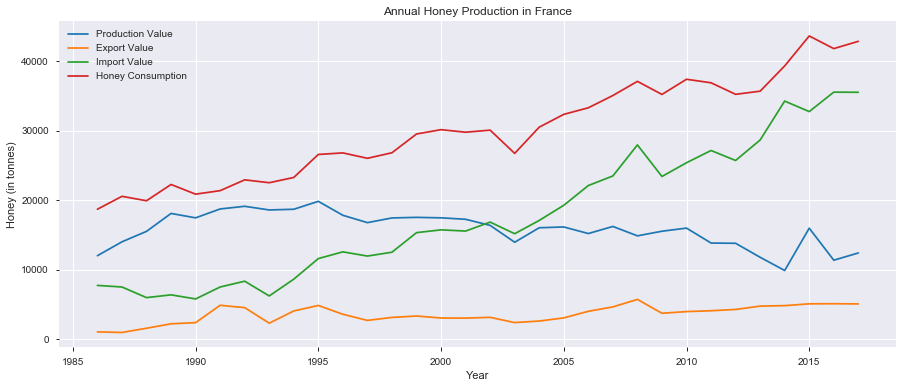

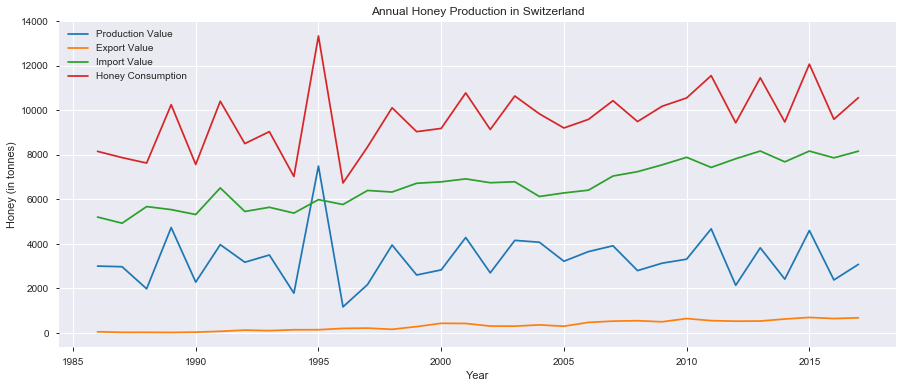

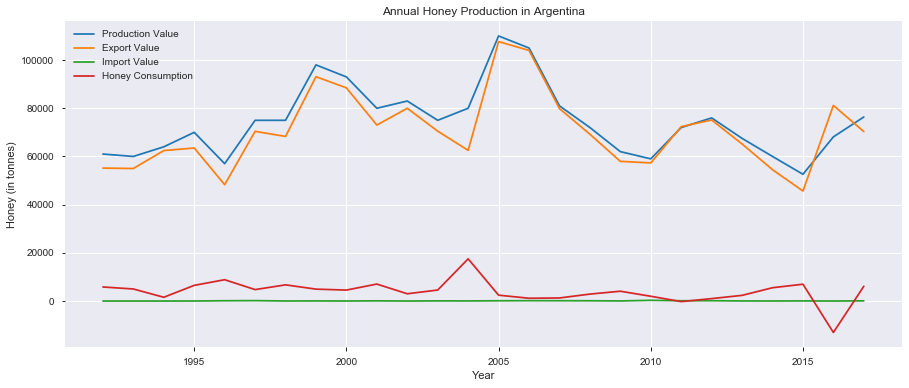

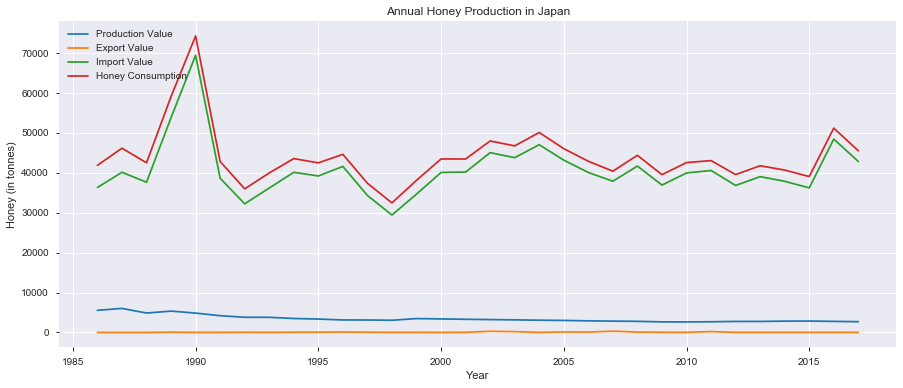

In [220]:

names = ["Production Value", "Export Value", "Import Value", "Honey Consumption"]
countries = ["United States of America", "China, mainland", "France", "Switzerland", "Argentina", "Japan"]
for country in countries:
    country_honey = new_df[new_df["Country"] == country]
    plot_time_series(country_honey, names,'Honey (in tonnes)', 'Year', f'Annual Honey Production in {country}')
plt.show()

We can observe 3 different kind of countries:
the countries which export the greater part of their honey production (Argentina)
the countries which import the greater part of their honey (France, USA, Japan)
the countries which use the greater part of their honey (China)

We can see in some countries 

In [93]:
top_exports_country_year = exports_country.groupby("Year").apply(lambda x: x.nlargest(5,['Export Value']))
top_exports_country_year.head(10)

Export Value
Year Year Country                      
1986 1986 Mexico                  24798
          USSR                    20607
          Argentina               18601
          Hungary                 11084
          Canada                  10657
1987 1987 China, mainland         50189
          Argentina               25227
          Mexico                  16941
          Hungary                 10341
          Canada                   9297

In [94]:
top_imports_country_year = imports_country.groupby("Year").apply(lambda x: x.nlargest(5,['Import Value']))
top_imports_country_year

Import Value
Year Year Country                               
1986 1986 United States of America         53536
          Japan                            36313
          United Kingdom                   21119
          Italy                             8181
          France                            7716
1987 1987 Japan                            40129
          United States of America         26299
          United Kingdom                   22833
          Italy                             9126
          Spain                             8017
1988 1988 Japan                            37638
          United States of America         24287
          United Kingdom                   22573
          Spain                             7851
          Italy                             6358
1989 1989 Japan                            53812
          United States of America         34668
          United Kingdom                   20796
          Italy                             8481
          France                            6358
1990 1990 Japan                            69433
          United States of America         34836
          United Kingdom                   24713
          Italy                             9203
          Yugoslav SFR                      7161
1991 1991 Germany                          89197
          United States of America         41686
          Japan                            38627
          United Kingdom                   22272
          Italy                            10027
...                                          ...
2012 2012 United States of America        141019
          Germany                          84416
          Japan                            36823
          United Kingdom                   34818
          France                           25719
2013 2013 United States of America        152849
          Germany                          88203
          Japan                            39030
          United Kingdom                   38142
          France                           28670
2014 2014 United States of America        165943
          Germany                          84391
          United Kingdom                   38436
          Japan                            37868
          France                           34281
2015 2015 United States of America        175208
          Germany                          90426
          United Kingdom                   41034
          Japan                            36222
          France                           32765
2016 2016 United States of America        166479
          Germany                          83926
          Japan                            48445
          United Kingdom                   39949
          France                           35568
2017 2017 United States of America        202565
          Germany                          93069
          United Kingdom                   44983
          Japan                            42823
          France                           35546

[160 rows x 1 columns]

In [9]:
pandas_profiling.ProfileReport(honey_imports)

## 4. What is the relation between US cases of Colony Collapse Disorder and the main factors of CCD?

Arthur

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Tim & Arthur